In [ ]:
# https://drive.google.com/drive/folders/1qG5mXi0-jwzXuYT33VR0kKjeJvjhJ19p?usp=sharing
# whole project folder

# Uploading the model

In [1]:
# TranSalNet_Res model from: https://github.com/LJOVO/TranSalNet
# uploaded into the session

from google.colab import files
uploaded = files.upload()

Saving fine-tune&train.ipynb to fine-tune&train.ipynb
Saving LICENSE to LICENSE
Saving README.md to README.md
Saving testing.ipynb to testing.ipynb
Saving TranSalNet_Dense.py to TranSalNet_Dense.py
Saving TranSalNet_Res.py to TranSalNet_Res.py


In [108]:
import os
import torch
import cv2
import numpy as np
import pandas as pd
from torchvision import transforms, utils, models
import torch.nn as nn
from tqdm import tqdm
from utils.data_process import preprocess_img, postprocess_img
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

flag = 1 # 0 for TranSalNet_Dense, 1 for TranSalNet_Res

In [5]:
# Load the model and pre-trained parameters

if flag:
    from TranSalNet_Res import TranSalNet
    model = TranSalNet()
    model.load_state_dict(torch.load(r'pretrained_models/TranSalNet_Res.pth'))
else:
    from TranSalNet_Dense import TranSalNet
    model = TranSalNet()
    model.load_state_dict(torch.load(r'pretrained_models\TranSalNet_Dense.pth'))

model = model.to(device)
model.eval()

TranSalNet(
  (encoder): _Encoder(
    (encoder): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
      

# Data preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
PATH = '/content/drive/MyDrive/CPM II/saliency_project/data/'

In [24]:
import os
from os import listdir
from os.path import join

def load_dataset(name):
  # returns a list of image paths and a list of saliency map paths
  if name not in ["ART", "EMOTION", "CAT2000"]:
    raise ValueError("Dataset not found")

  image_paths = []
  map_paths = []


  if name == "CAT2000":
    folder_name, ending = "trainSet/FIXATIONMAPS", ".jpg"
    folder_file_names =  []

    for _, folder in enumerate(os.listdir(PATH + folder_name)):
      folder_path = join(folder)
      for idx, image in enumerate(os.listdir(PATH + folder_name + "/" + folder_path)):
        if idx < 20: # take only 20 examples from each of 20 inner folders (categories)
          image_path = join(folder_path, image)
          if image_path.endswith(ending):
            folder_file_names.append(image_path)
    folder_file_names.sort()
    image_paths = ["trainSet/Stimuli/"+ name for name in folder_file_names]
    map_paths = ["trainSet/FIXATIONMAPS/"+ name for name in folder_file_names]


  else:
    if name == "ART":
      image_folder, map_folder, ending = "ART/stimuli", "ART/saliencyMaps", ".png"
    elif name == "EMOTION":
      image_folder, map_folder, ending = "EMOTIONS/EMOdImages1019", "EMOTIONS/FixationMap/Continous_map", ".jpg"

    for _, image in enumerate(os.listdir(PATH + image_folder)):
      image_path = join(image_folder, image)
      if image_path.endswith(ending):
        image_paths.append(image_path)
    for _, map in enumerate(os.listdir(PATH + map_folder)):
      map_path = join(map_folder, map)
      if map_path.endswith(ending):
        map_paths.append(map_path)


  image_paths.sort()
  map_paths.sort()

  if name == "EMOTION":
    map_paths = map_paths[:698]

  return image_paths, map_paths


In [68]:
image_paths, map_paths = load_dataset("ART")
# 'ART' - 150, 'EMOTION' - 698, 'CAT2000' - 400 images

In [69]:
map_paths[75:85]

['ART/saliencyMaps/dead_hare_ward.png',
 'ART/saliencyMaps/delacroix-Reclining-Odalisque-or-Woman-with-a-Parakeet-1827.png',
 'ART/saliencyMaps/delacroix-still-life-with-lobsters-1827.png',
 'ART/saliencyMaps/female_nude_reclining_on-a_divan_delacroix_1826.png',
 'ART/saliencyMaps/flowers-and-fruit-a-melon_fantin-latour_1865.png',
 'ART/saliencyMaps/garlic-cloves-and-knife-on-the-corner-of-a-table_caillebotte_1871.png',
 'ART/saliencyMaps/goya-Bodegon-con-salmon-1812.png',
 'ART/saliencyMaps/goya-Bodegones-con-pargos-dorados-1812.png',
 'ART/saliencyMaps/goya-Nature-morte-avec-Bouteilles-et-Pains-1826.png',
 'ART/saliencyMaps/goya-Pavo-muerto-1812.png']

# Base model performance

## SSIM scores for all 3 datasets

In [62]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(image_paths, map_paths):
  ssim_results = []
  # used later to adjust to original image sizes
  if image_paths[0].split('/')[0] == "trainSet":
    size = (1080, 1920)
  elif image_paths[0].split('/')[0] == "ART":
    size = (900, 1600)
  else:
    size = (768, 1024)

  for image, map in zip(image_paths, map_paths):
    test_img = PATH+image

    img = preprocess_img(test_img) # padding and resizing input image into 384x288
    img = np.array(img)/255.
    img = np.expand_dims(np.transpose(img,(2,0,1)),axis=0)
    img = torch.from_numpy(img)
    img = img.type(torch.cuda.FloatTensor).to(device)
    pred_saliency = model(img)
    toPIL = transforms.ToPILImage()
    pic = toPIL(pred_saliency.squeeze())

    pred_saliency = postprocess_img(pic, test_img) # restore the image to its original size as the result

    im_frame = Image.open(PATH+map)
    true_saliency = np.array(im_frame.getdata()).reshape(size)

    ssim_index, ssim_map = ssim(pred_saliency, true_saliency, full=True)
    ssim_results.append(ssim_index)

  return ssim_results

In [71]:
ssim_results = calculate_ssim(image_paths, map_paths)

In [94]:
# load calculated results (for CAT200)
ssim_results = np.load("/content/drive/MyDrive/CPM II/saliency_project/results/base_model/base_ssim_cat.npy")
np.mean(ssim_results)

0.47251538684294253

## Generating example saliency maps

In [95]:
def generate_map(image_path, save_to_path):
  test_img = PATH + image_path

  img = preprocess_img(test_img) # padding and resizing input image into 384x288
  img = np.array(img)/255.
  img = np.expand_dims(np.transpose(img,(2,0,1)),axis=0)
  img = torch.from_numpy(img)
  img = img.type(torch.cuda.FloatTensor).to(device)
  pred_saliency = model(img)
  toPIL = transforms.ToPILImage()
  pic = toPIL(pred_saliency.squeeze())

  pred_saliency = postprocess_img(pic, test_img) # restore the image to its original size as the result

  cv2.imwrite(save_to_path, pred_saliency, [int(cv2.IMWRITE_JPEG_QUALITY), 100]) # save the result
  print('Finished, check the result at: {}'.format(save_to_path))

In [101]:
generate_map(image_paths[148], r"max_pred_sal.png") # for: 'ART/stimuli/woman-at-her-toilette_degas_1877.png'

Finished, check the result at: max_pred_sal.png


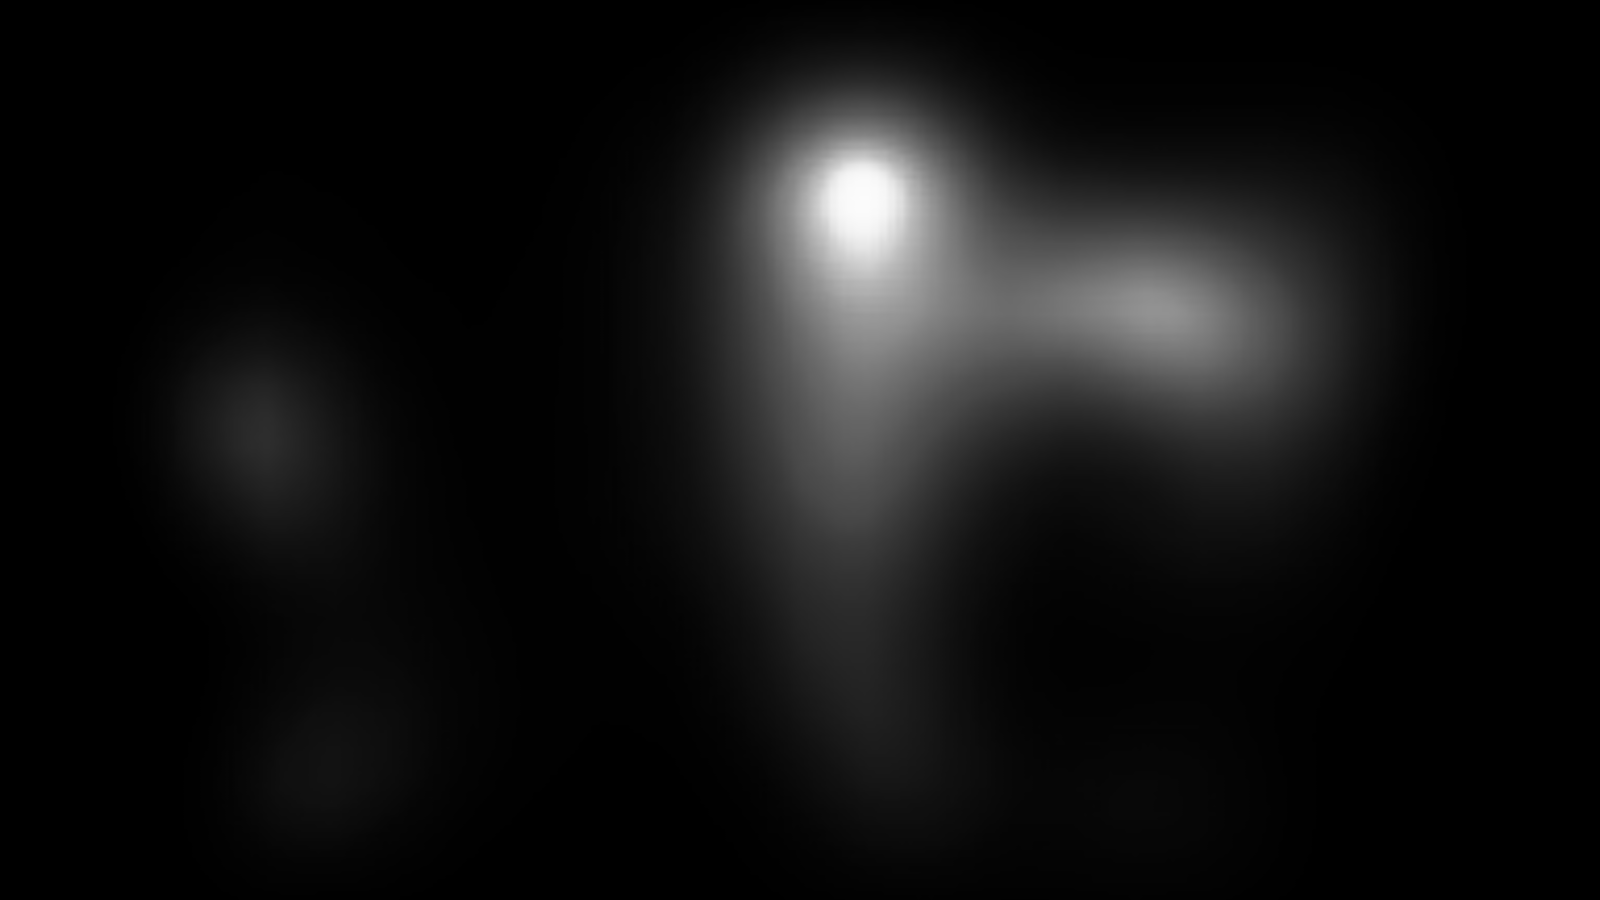

In [106]:
from IPython.display import Image, display
display(Image("max_pred_sal.png", width=600))

# Fine-tuning

In [111]:
import os
import time
import copy
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm

from utils.loss_function import SaliencyLoss
from utils.data_process import MyDataset

flag = 1 # 0 for TranSalNet_Dense, 1 for TranSalNet_Res

if flag:
    from TranSalNet_Res import TranSalNet
else:
    from TranSalNet_Dense import TranSalNet

## Re-sizing images, saliency and fixation maps

In [110]:
from PIL import Image
import os
from google.colab import files

Image.MAX_IMAGE_PIXELS = None


# resize all ART and EMO images + maps for training
def resize_aspect_fit(path, new_size, path_to):
    dirs = os.listdir(path)
    for item in dirs:
        if item == '.DS_Store':
            continue

        if item == 'Icon\r':
            continue

        if item.endswith(".mp4"):
            continue

        if item.endswith(".txt"):
            continue

        if item.endswith(".db"):
            continue

        if os.path.isfile(path+item):
            image = Image.open(path+item)
            file_path, extension = os.path.splitext(path+item)

            image = image.resize(new_size, Image.ANTIALIAS)
            image.save(path_to + item)



#resize_aspect_fit("/content/drive/MyDrive/CPM II/saliency_project/data/EMOTIONS/FixationMap/Continous_map/", (384, 288), "/content/drive/MyDrive/CPM II/saliency_project/data/EMOTIONS/FixationMap/res_Continous_map/")

## Fine-tuning on ART

In [ ]:
PATH = '/content/drive/MyDrive/CPM II/saliency_project/data/ART/'

In [ ]:
import os
from os import listdir
from os.path import join

ART_img_paths = []
ART_sal_paths = []
ART_fix_paths = []

for _, img in enumerate(os.listdir(PATH+"res_stimuli")):
  img_path = join(img)
  if img_path.endswith('.png'):
    ART_img_paths.append(img_path)

for _, sal in enumerate(os.listdir(PATH+"res_saliencyMaps")):
  sal_path = join(sal)
  if sal_path.endswith('.png'):
    ART_sal_paths.append(sal_path)

for _, fix in enumerate(os.listdir(PATH+"res_fixationMaps")):
  fix_path = join(fix)
  if fix_path.endswith('.png'):
    ART_fix_paths.append(fix_path)

ART_img_paths.sort()
ART_sal_paths.sort()
ART_fix_paths.sort()

In [ ]:
ART_dataset = pd.DataFrame(list(zip(ART_img_paths, ART_sal_paths, ART_fix_paths)),
                           columns =['image', 'saliency', 'fixation'])

ART_dataset.head(10)

,image,saliency,fixation
0,A_Highland_Landscape_Landseer_1830.png,A_Highland_Landscape_Landseer_1830.png,A_Highland_Landscape_Landseer_1830.png
1,Alfalfa_St-Denis_Seurat_1886.png,Alfalfa_St-Denis_Seurat_1886.png,Alfalfa_St-Denis_Seurat_1886.png
2,Automne_En_France_Carr_1911.png,Automne_En_France_Carr_1911.png,Automne_En_France_Carr_1911.png
3,Bank_Of_A_Lake_Pechstein_1910.png,Bank_Of_A_Lake_Pechstein_1910.png,Bank_Of_A_Lake_Pechstein_1910.png
4,Courbet-Femme-nue-couchee-1862.png,Courbet-Femme-nue-couchee-1862.png,Courbet-Femme-nue-couchee-1862.png
5,Delacroix-odalisque-1825.png,Delacroix-odalisque-1825.png,Delacroix-odalisque-1825.png
6,Fleurs_et_fruits_camoin_1942.png,Fleurs_et_fruits_camoin_1942.png,Fleurs_et_fruits_camoin_1942.png
7,Georges-braque-still-life-with-jugs-and-pipe-1...,Georges-braque-still-life-with-jugs-and-pipe-1...,Georges-braque-still-life-with-jugs-and-pipe-1...
8,Girtin-Kirkstall-Abbey-Yorkshire-1801.png,Girtin-Kirkstall-Abbey-Yorkshire-1801.png,Girtin-Kirkstall-Abbey-Yorkshire-1801.png
9,Hayet-Nature-morte-1888.png,Hayet-Nature-morte-1888.png,Hayet-Nature-morte-1888.png


In [ ]:
# held-out 15% for testing + 15% for val
ART_val_test_ids = ART_dataset.sample(frac = 0.30, random_state=1234)
df_shuffled = ART_val_test_ids.sample(frac=1, random_state=1234)
df_splits = np.array_split(df_shuffled, 2)
ART_test_ids = df_splits[0] # (23, 3)
ART_val_ids = df_splits[1] # (22, 3)

# rest of 70% values for training
ART_train_ids = ART_dataset.drop(ART_val_test_ids.index) # (105, 3)

In [ ]:
print(ART_train_ids.iloc[1])
print(ART_val_ids.iloc[1])

dataset_sizes = {'train':len(ART_train_ids),'val':len(ART_val_ids)}
print(dataset_sizes)

image       Alfalfa_St-Denis_Seurat_1886.png
saliency    Alfalfa_St-Denis_Seurat_1886.png
fixation    Alfalfa_St-Denis_Seurat_1886.png
Name: 1, dtype: object
image       mother_and_child_by_the_sea_dahl_1830.png
saliency    mother_and_child_by_the_sea_dahl_1830.png
fixation    mother_and_child_by_the_sea_dahl_1830.png
Name: 103, dtype: object
{'train': 105, 'val': 22}


In [ ]:
# Set batch_size and Load dataset

batch_size = 4
train_set = MyDataset(ids=ART_train_ids,
                           stimuli_dir= PATH + "res_stimuli/",
                           saliency_dir= PATH + "res_saliencyMaps/",
                           fixation_dir= PATH + "res_fixationMaps/",
                           transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]))

val_set = MyDataset(ids=ART_val_ids,
                        stimuli_dir= PATH + "res_stimuli/",
                        saliency_dir = PATH + "res_saliencyMaps/",
                        fixation_dir= PATH + "res_fixationMaps/",
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]))



dataloaders = {'train':DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=4)
               ,'val':DataLoader(val_set, batch_size=batch_size,shuffle=False, num_workers=4)}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Fine-tuning on EMOTIONS

In [ ]:
PATH = '/content/drive/MyDrive/CPM II/saliency_project/data/EMOTIONS/'

In [ ]:
import os
from os import listdir
from os.path import join

EMO_img_paths = []
EMO_sal_paths = []
EMO_fix_paths = []

for _, img in enumerate(os.listdir(PATH+"res_EMOdImages1019")):
  img_path = join(img)
  if img_path.endswith('.jpg'):
    EMO_img_paths.append(img_path)

for _, sal in enumerate(os.listdir(PATH+"FixationMap/res_Continous_map")):
  sal_path = join(sal)
  if sal_path.endswith('.jpg'):
    EMO_sal_paths.append(sal_path)

for _, fix in enumerate(os.listdir(PATH+"FixationMap/res_Binary_map")):
  fix_path = join(fix)
  if fix_path.endswith('.jpg'):
    EMO_fix_paths.append(fix_path)

EMO_img_paths.sort()
EMO_sal_paths.sort()
EMO_fix_paths.sort()

In [ ]:
EMO_sal_paths = [x for x in EMO_sal_paths if x in EMO_img_paths]
EMO_fix_paths = [x for x in EMO_fix_paths if x in EMO_img_paths]

In [ ]:
EMO_dataset = pd.DataFrame(list(zip(EMO_img_paths, EMO_sal_paths, EMO_fix_paths)),
                           columns =['image', 'saliency', 'fixation'])

EMO_dataset.head(10)

,image,saliency,fixation
0,0001.jpg,0001.jpg,0001.jpg
1,0002.jpg,0002.jpg,0002.jpg
2,0003.jpg,0003.jpg,0003.jpg
3,0004.jpg,0004.jpg,0004.jpg
4,0005.jpg,0005.jpg,0005.jpg
5,0006.jpg,0006.jpg,0006.jpg
6,0007.jpg,0007.jpg,0007.jpg
7,0008.jpg,0008.jpg,0008.jpg
8,0009.jpg,0009.jpg,0009.jpg
9,0010.jpg,0010.jpg,0010.jpg


In [ ]:
# held-out 15% for testing + 15% for val
EMO_val_test_ids = EMO_dataset.sample(frac = 0.30, random_state=1234)
df_shuffled = EMO_val_test_ids.sample(frac=1, random_state=1234)
df_splits = np.array_split(df_shuffled, 2)
EMO_test_ids = df_splits[0] # (104, 3)
EMO_val_ids = df_splits[1] # (104, 3)

# rest of 70% values for training
EMO_train_ids = EMO_dataset.drop(EMO_val_test_ids.index) # (485, 3)

In [ ]:
print(EMO_train_ids.iloc[1])
print(EMO_val_ids.iloc[1])

dataset_sizes = {'train':len(EMO_train_ids),'val':len(EMO_val_ids)}
print(dataset_sizes)

image       0002.jpg
saliency    0002.jpg
fixation    0002.jpg
Name: 1, dtype: object
image       0681.jpg
saliency    0681.jpg
fixation    0681.jpg
Name: 679, dtype: object
{'train': 485, 'val': 104}


In [ ]:
# Set batch_size and Load dataset

batch_size = 4
train_set = MyDataset(ids=EMO_train_ids,
                           stimuli_dir= PATH + "res_EMOdImages1019/",
                           saliency_dir= PATH + "FixationMap/res_Continous_map/",
                           fixation_dir= PATH + "FixationMap/res_Binary_map/",
                           transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]))

val_set = MyDataset(ids=EMO_val_ids,
                        stimuli_dir= PATH + "res_EMOdImages1019/",
                        saliency_dir = PATH + "FixationMap/res_Continous_map/",
                        fixation_dir= PATH + "FixationMap/res_Binary_map/",
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]))



dataloaders = {'train':DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=4)
               ,'val':DataLoader(val_set, batch_size=batch_size,shuffle=False, num_workers=4)}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Common part

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = TranSalNet()
model.load_state_dict(torch.load(r'pretrained_models/TranSalNet_Res.pth')) #FINE_TUNING!!!
model = model.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

loss_fn = SaliencyLoss()

'''Training'''
best_model_wts = copy.deepcopy(model.state_dict())
num_epochs = 4
best_loss = 100
for k,v in model.named_parameters():
    print('{}: {}'.format(k, v.requires_grad))


for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0


        # Iterate over data.
        for i_batch, sample_batched in tqdm(enumerate(dataloaders[phase])):
            stimuli, smap, fmap = sample_batched['image'], sample_batched['saliency'], sample_batched['fixation']
            stimuli, smap, fmap = stimuli.type(torch.cuda.FloatTensor), smap.type(torch.cuda.FloatTensor), fmap.type(torch.cuda.FloatTensor)
            stimuli, smap, fmap = stimuli.to(device), smap.to(device), fmap.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(stimuli)



                loss = -2*loss_fn(outputs,smap,loss_type='cc')\
                        -1*loss_fn(outputs,smap,loss_type='sim')+\
                        10*loss_fn(outputs,smap,loss_type='kldiv')-1*loss_fn(outputs,fmap,loss_type='nss')



                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * stimuli.size(0)



        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]


        print('{} Loss: {:.4f}'.format(
            phase, epoch_loss))


        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        elif phase == 'val' and epoch_loss >= best_loss:
            counter += 1
            if counter ==5:
                print('early stop!')
                break
    else:
        continue
    break
    print()


print('Best val loss: {:4f}'.format(best_loss))
model.load_state_dict(best_model_wts)

savepath = r'fine_emo.pth'
torch.save(model.state_dict(),savepath)

encoder.encoder.0.weight: True
encoder.encoder.1.weight: True
encoder.encoder.1.bias: True
encoder.encoder.4.0.conv1.weight: True
encoder.encoder.4.0.bn1.weight: True
encoder.encoder.4.0.bn1.bias: True
encoder.encoder.4.0.conv2.weight: True
encoder.encoder.4.0.bn2.weight: True
encoder.encoder.4.0.bn2.bias: True
encoder.encoder.4.0.conv3.weight: True
encoder.encoder.4.0.bn3.weight: True
encoder.encoder.4.0.bn3.bias: True
encoder.encoder.4.0.downsample.0.weight: True
encoder.encoder.4.0.downsample.1.weight: True
encoder.encoder.4.0.downsample.1.bias: True
encoder.encoder.4.1.conv1.weight: True
encoder.encoder.4.1.bn1.weight: True
encoder.encoder.4.1.bn1.bias: True
encoder.encoder.4.1.conv2.weight: True
encoder.encoder.4.1.bn2.weight: True
encoder.encoder.4.1.bn2.bias: True
encoder.encoder.4.1.conv3.weight: True
encoder.encoder.4.1.bn3.weight: True
encoder.encoder.4.1.bn3.bias: True
encoder.encoder.4.2.conv1.weight: True
encoder.encoder.4.2.bn1.weight: True
encoder.encoder.4.2.bn1.bias: T

122it [01:45,  1.16it/s]

train Loss: 1.6721



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
26it [00:24,  1.07it/s]

val Loss: 1.3951
Epoch 2/4
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
122it [01:28,  1.37it/s]

train Loss: 0.4849



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
26it [00:26,  1.00s/it]

val Loss: 1.2378
Epoch 3/4
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
122it [01:31,  1.34it/s]

train Loss: -0.1279



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
26it [00:21,  1.18it/s]

val Loss: 1.0705
Epoch 4/4
----------



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
122it [01:34,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: -0.6522


26it [00:26,  1.02s/it]


val Loss: 1.0459
Best val loss: 1.045860


## Testing fine-tuned models

In [ ]:
from skimage.metrics import structural_similarity as ssim
ssim_results = []

for image in list(EMO_test_ids.iloc[:, 0]):
  test_img = PATH+"EMOdImages1019/"+image

  img = preprocess_img(test_img) # padding and resizing input image into 384x288
  img = np.array(img)/255.
  img = np.expand_dims(np.transpose(img,(2,0,1)),axis=0)
  img = torch.from_numpy(img)
  img = img.type(torch.cuda.FloatTensor).to(device)
  pred_saliency = model(img)
  toPIL = transforms.ToPILImage()
  pic = toPIL(pred_saliency.squeeze())

  pred_saliency = postprocess_img(pic, test_img) # restore the image to its original size as the result

  im_frame = Image.open(PATH+"FixationMap/Continous_map/"+image)
  true_saliency = np.array(im_frame.getdata()).reshape((768, 1024)) #(900, 1600) or (768, 1024)

  ssim_index, ssim_map = ssim(pred_saliency, true_saliency, full=True)
  ssim_results.append(ssim_index)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarnin

# Additional analysis - 3 models on CAT2000

In [112]:
ssim_base = np.load("/content/drive/MyDrive/CPM II/saliency_project/results/base_model/base_ssim_cat.npy")
ssim_art = np.load("/content/drive/MyDrive/CPM II/saliency_project/results/pretrained_art/art_ssim_cat.npy")
ssim_emo = np.load("/content/drive/MyDrive/CPM II/saliency_project/results/pretrained_emo/emo_ssim_cat.npy")

In [119]:
image_paths, _ = load_dataset("CAT2000")
ssim_df = pd.DataFrame(list(zip(image_paths, ssim_base, ssim_art, ssim_emo)),
                         columns =['image', 'base', 'art', 'emo'])
ssim_df.head(10)

,image,base,art,emo
0,trainSet/Stimuli/Action/003.jpg,0.702190,0.729376,0.790753
1,trainSet/Stimuli/Action/015.jpg,0.815585,0.722351,0.826310
2,trainSet/Stimuli/Action/017.jpg,0.782945,0.681224,0.747034
3,trainSet/Stimuli/Action/027.jpg,0.710357,0.648626,0.747018
4,trainSet/Stimuli/Action/029.jpg,0.676196,0.662923,0.778332
5,trainSet/Stimuli/Action/045.jpg,0.637659,0.602236,0.752356
6,trainSet/Stimuli/Action/053.jpg,0.718199,0.705265,0.774904
7,trainSet/Stimuli/Action/055.jpg,0.787520,0.728433,0.763834
8,trainSet/Stimuli/Action/067.jpg,0.530632,0.483337,0.584850
9,trainSet/Stimuli/Action/069.jpg,0.786526,0.618993,0.692757


In [120]:
cat = ssim_df['image'].apply(lambda x: x.split('/')[2])
ssim_df['category'] = cat
ssim_df.head(10)

,image,base,art,emo,category
0,trainSet/Stimuli/Action/003.jpg,0.702190,0.729376,0.790753,Action
1,trainSet/Stimuli/Action/015.jpg,0.815585,0.722351,0.826310,Action
2,trainSet/Stimuli/Action/017.jpg,0.782945,0.681224,0.747034,Action
3,trainSet/Stimuli/Action/027.jpg,0.710357,0.648626,0.747018,Action
4,trainSet/Stimuli/Action/029.jpg,0.676196,0.662923,0.778332,Action
5,trainSet/Stimuli/Action/045.jpg,0.637659,0.602236,0.752356,Action
6,trainSet/Stimuli/Action/053.jpg,0.718199,0.705265,0.774904,Action
7,trainSet/Stimuli/Action/055.jpg,0.787520,0.728433,0.763834,Action
8,trainSet/Stimuli/Action/067.jpg,0.530632,0.483337,0.584850,Action
9,trainSet/Stimuli/Action/069.jpg,0.786526,0.618993,0.692757,Action


In [127]:
df_plot = ssim_df.groupby('category').mean()
df_plot.reset_index(inplace = True)
df_plot

,category,base,art,emo
0,Action,0.726379,0.680230,0.761061
1,Affective,0.650277,0.666552,0.742330
2,Art,0.579518,0.616062,0.687432
3,BlackWhite,0.461824,0.557584,0.629212
4,Cartoon,0.546176,0.589084,0.650716
5,Fractal,0.365359,0.506898,0.536635
6,Indoor,0.434358,0.539734,0.649337
7,Inverted,0.476336,0.560562,0.658309
8,Jumbled,0.448603,0.550520,0.668180
9,LineDrawing,0.319013,0.454285,0.544190


In [124]:
import scipy.stats as stats
print(stats.ttest_ind(a=df_plot.loc[:, 'base'], b=df_plot.loc[:, 'art'],equal_var=False))
print(stats.ttest_ind(a=df_plot.loc[:, 'base'], b=df_plot.loc[:, 'emo'],equal_var=False))
print(stats.ttest_ind(a=df_plot.loc[:, 'emo'], b=df_plot.loc[:, 'art'],equal_var=False))

Ttest_indResult(statistic=-2.418261681134973, pvalue=0.021897707865733133)
Ttest_indResult(statistic=-3.746480119179274, pvalue=0.0006210436135099707)
Ttest_indResult(statistic=2.0753400969888944, pvalue=0.045606795738073906)


<Axes: title={'center': 'Mean SSIM scores for each CAT2000 category'}, xlabel='category'>

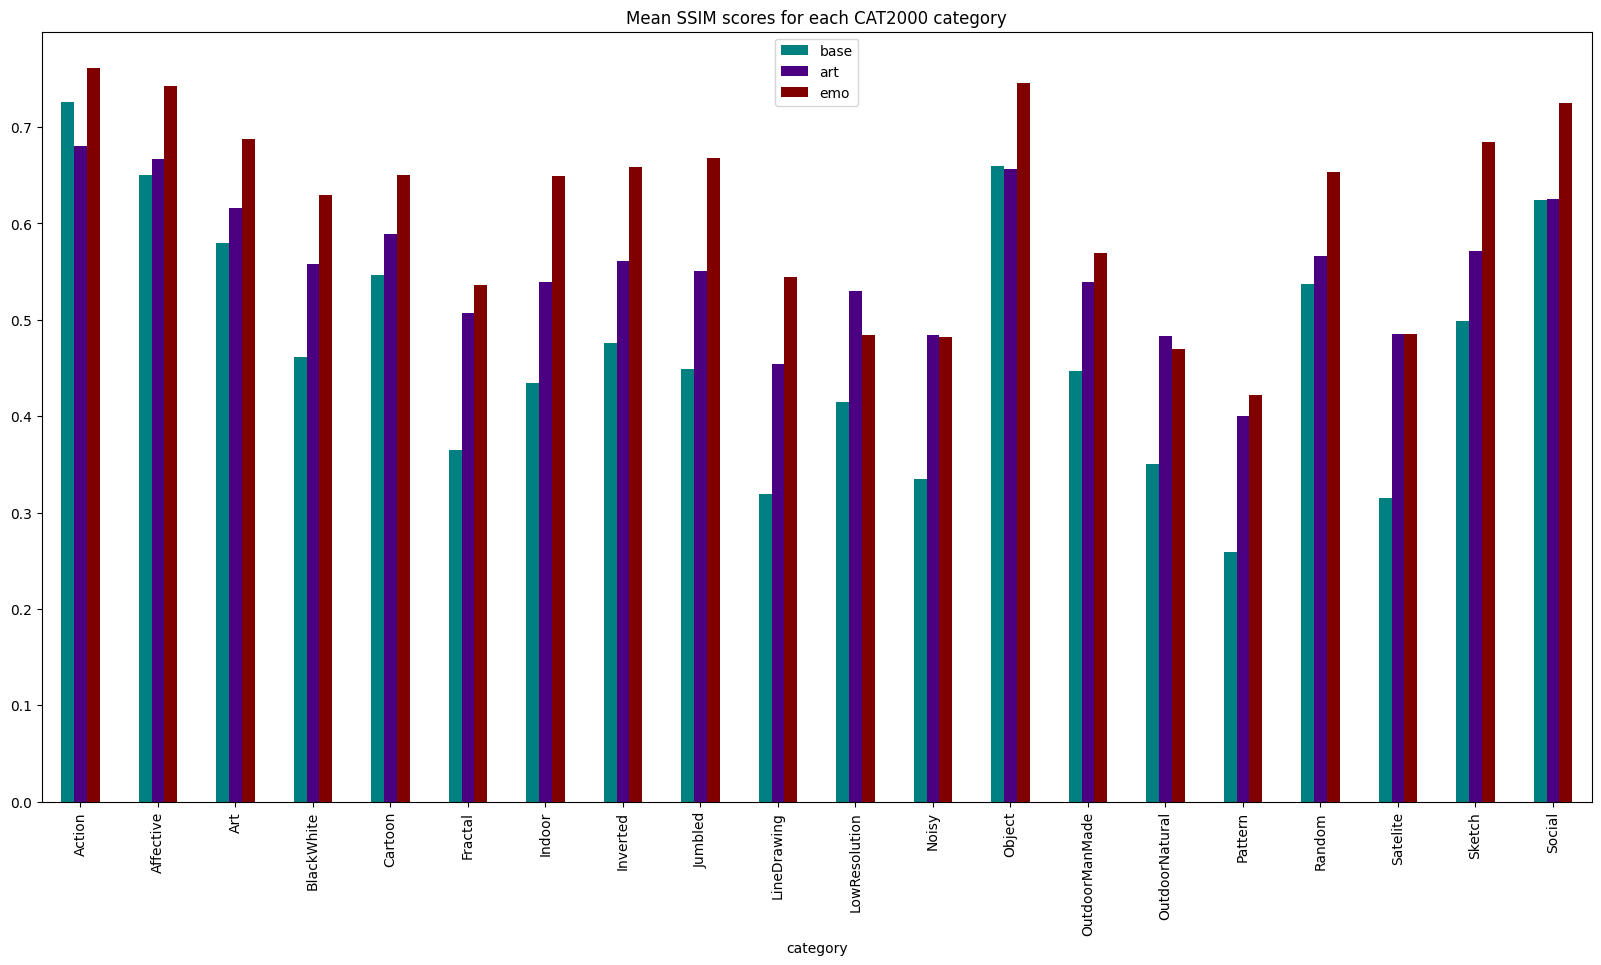

In [126]:
import matplotlib.pyplot as plt

df_plot.plot(x='category',
        kind='bar',
        stacked=False,
        title='Mean SSIM scores for each CAT2000 category',
        figsize=(20, 10),
        color = ['teal', 'indigo', 'maroon'])
        #colormap = 'Dark2')